# EmoDB Notebook

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np 
import glob
import os
from os.path import isfile, join
import soundfile as sf 
import sys
import librosa 
import librosa.display
import seaborn as sbn
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from IPython.display import Audio
import scipy.io.wavfile
from scipy.fftpack import dct
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

In [2]:
# Folder path
EmodbData = "C:/Users/Lenovo/Documents/3rd Year Project/Dataset/EmoDB/"

In [32]:
# Extract data from folder
fileEmotion = []
filePath = []
EmodbList = os.listdir(EmodbData)
for dir in EmodbList:
    filePath.append(EmodbData + dir)
    fileEmotion.append(dir[5])
    
dfEmotion = pd.DataFrame(fileEmotion, columns=['Emotions'])
dfPath = pd.DataFrame(filePath, columns=['Path'])
dfEmodb = pd.concat([dfEmotion, dfPath], axis=1)
dfPath = pd.concat([dfEmodb], axis = 0)
dfEmodb.head()

,Emotions,Path
0,F,C:/Users/Lenovo/Documents/3rd Year Project/Dat...
1,N,C:/Users/Lenovo/Documents/3rd Year Project/Dat...
2,W,C:/Users/Lenovo/Documents/3rd Year Project/Dat...
3,F,C:/Users/Lenovo/Documents/3rd Year Project/Dat...
4,N,C:/Users/Lenovo/Documents/3rd Year Project/Dat...


In [34]:
dfEmodb['Emotions'].value_counts()

W    127
L     81
N     79
F     71
A     69
T     62
E     46
Name: Emotions, dtype: int64

In [41]:
# Save files of the four emotions
fileDuration = 0
fileDuration = []
label = 0
label = []
path1 = 0
path1 = []
count = 0
for i in range(len(dfEmodb)):
    if dfEmodb['Emotions'][i] == 'F':
        count = count +1
        label.append(dfEmodb['Emotions'][i])
        path1.append(dfEmodb['Path'][i])
        signal, sr = librosa.load(dfEmodb['Path'][i])
        fileDuration.append(len(signal))
        
    if dfEmodb['Emotions'][i] == 'N':
        count = count +1
        label.append(dfEmodb['Emotions'][i])
        path1.append(dfEmodb['Path'][i])
        signal, sr = librosa.load(dfEmodb['Path'][i])
        fileDuration.append(len(signal))
        
    if dfEmodb['Emotions'][i] == 'W':
        count = count +1
        label.append(dfEmodb['Emotions'][i])
        path1.append(dfEmodb['Path'][i])
        signal, sr = librosa.load(dfEmodb['Path'][i])
        fileDuration.append(len(signal))
        
    if dfEmodb['Emotions'][i] == 'T':
        count = count +1
        label.append(dfEmodb['Emotions'][i])
        path1.append(dfEmodb['Path'][i])
        signal, sr = librosa.load(dfEmodb['Path'][i])
        fileDuration.append(len(signal))
        
    
print(count)

339


In [43]:
# Create new dataframe
dfEmodb_shortened = pd.DataFrame(
    {'Label': label,
     'Path': path1,
     'Duration': fileDuration
    })

In [53]:
dfEmodb_shortened.Label.replace({'W':'Anger','F':'Happiness', 'T':'Sadness', 'N':'Neutral'}, inplace=True)
dfEmodb_shortened

,Label,Path,Duration
0,Happiness,C:/Users/Lenovo/Documents/3rd Year Project/Dat...,41857
1,Neutral,C:/Users/Lenovo/Documents/3rd Year Project/Dat...,35529
2,Anger,C:/Users/Lenovo/Documents/3rd Year Project/Dat...,41406
3,Happiness,C:/Users/Lenovo/Documents/3rd Year Project/Dat...,44238
4,Neutral,C:/Users/Lenovo/Documents/3rd Year Project/Dat...,31748
...,...,...,...
334,Happiness,C:/Users/Lenovo/Documents/3rd Year Project/Dat...,56967
335,Sadness,C:/Users/Lenovo/Documents/3rd Year Project/Dat...,77189
336,Sadness,C:/Users/Lenovo/Documents/3rd Year Project/Dat...,86749
337,Anger,C:/Users/Lenovo/Documents/3rd Year Project/Dat...,53232


Anger        127
Neutral       79
Happiness     71
Sadness       62
Name: Label, dtype: int64

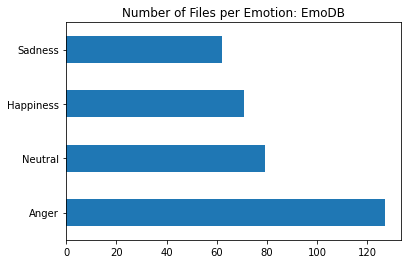

In [73]:
# Compute distribution of files
distribution = dfEmodb_shortened['Label'].value_counts().plot(kind='barh', title='Number of Files per Emotion: EmoDB')
dfEmodb_shortened['Label'].value_counts()


In [70]:
# Compute the distribution of file lengths
avgDuration = sum(dfEmodb_shortened.Duration)/len(dfEmodb_shortened.Duration)
minDuration = min(dfEmodb_shortened.Duration)
maxDuration = max(dfEmodb_shortened.Duration)
print(avgDuration/sr)
print(minDuration/sr)
print(maxDuration/sr)

dfEmodb_shortened["Duration_sec"] = dfEmodb_shortened['Duration']/sr 

2.8131843022361354
1.4308390022675737
8.97827664399093


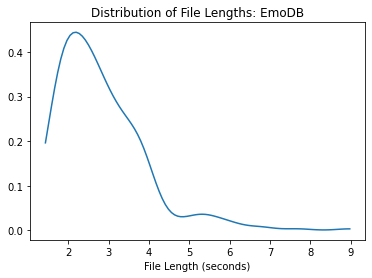

75.0% of files have a length shorter than 3.31 seconds.


In [84]:
# Plot distribution of file lengths
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

pdf = gaussian_kde(dfEmodb_shortened['Duration_sec'])
x = np.linspace(dfEmodb_shortened['Duration_sec'].min(), dfEmodb_shortened['Duration_sec'].max(), 100)
plt.plot(x,pdf(x))
plt.xlabel("File Length (seconds)")
plt.title("Distribution of File Lengths: EmoDB")
plt.show()

cdf = dfEmodb_shortened['Duration_sec'].value_counts(normalize=True).sort_index().cumsum()

threshold = 0.75
point = cdf[cdf <= threshold].index.max()
print(f"{threshold*100}% of files have a length shorter than {point:.2f} seconds.")

In [74]:
Crop files 
setfileDuration = 3.31*sr # set file duration to 3.31 seconds
newlabel = []
for path in dfEmodb_shortened.Path:
    savePath = 'C:/Users/Lenovo/Documents/3rd Year Project/Dataset/Emodb_Baseline/'+ path[57:]
    signal, sr = librosa.load(path)
    fileDuration = len(signal)
    if fileDuration != setfileDuration :
        # crop soundwave 
        trimmedFiles = librosa.util.fix_length(signal, int(setfileDuration))
        soundfile.write(savePath, trimmedFiles, sr)
    else:
        soundfile.write(savePath, signal, sr)
    newlabel.append(path[62])

In [88]:
# Extract MFCC features
from os import listdir
from os.path import isfile, join
data = []
label = []
Path = 'C:/Users/Lenovo/Documents/3rd Year Project/Dataset/Emodb_Baseline/'
files = [f for f in listdir(Path) if isfile(join(Path, f))]
for x in files:
    filePath = Path + x
    label.append(x[5])
    signal, sr = librosa.load(filePath, sr=None)
    mfcc = librosa.feature.mfcc(signal, n_fft=2048, hop_length = 256, n_mfcc = 18) 
    data.append(mfcc)

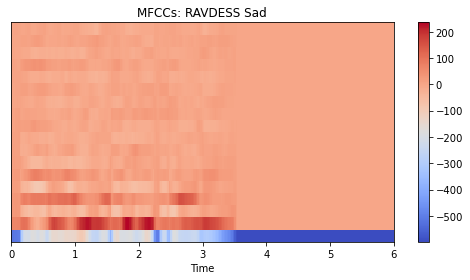

1


In [170]:
# Plot MFCC spectrogram
plt.figure(figsize=(7, 4))
librosa.display.specshow(data[5], x_axis='time', sr=sr)
plt.colorbar()
plt.title('MFCCs: RAVDESS Sad')
plt.tight_layout()
plt.show()
print(label[5])

In [89]:
# Relabel emotions numerically
for i in range(len(label)):
    if label[i] == 'W': # anger
        label[i] = 2
    if label[i] == 'N': # neutral
        label[i] = 3
    if label[i] == 'F': # happiness
        label[i] = 0
    if label[i] == 'T': # sadness
        label[i] = 1
print(label)

[0, 3, 2, 0, 3, 1, 2, 2, 0, 3, 1, 2, 0, 3, 1, 2, 2, 0, 0, 3, 2, 0, 3, 1, 2, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 3, 2, 2, 0, 3, 2, 2, 0, 3, 1, 2, 0, 3, 1, 2, 0, 3, 1, 2, 0, 3, 1, 1, 2, 0, 0, 3, 2, 0, 3, 1, 2, 0, 3, 1, 2, 0, 3, 1, 2, 2, 0, 3, 1, 2, 0, 3, 2, 2, 0, 3, 2, 3, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 1, 2, 2, 0, 0, 3, 1, 2, 3, 2, 3, 2, 3, 2, 0, 3, 2, 0, 3, 2, 2, 1, 2, 1, 2, 0, 3, 2, 1, 2, 2, 0, 2, 3, 2, 0, 3, 1, 2, 0, 3, 2, 0, 0, 3, 1, 2, 1, 2, 0, 3, 2, 0, 3, 1, 2, 0, 3, 1, 2, 2, 0, 3, 1, 2, 3, 1, 2, 0, 3, 2, 3, 2, 2, 2, 3, 1, 2, 2, 1, 2, 0, 3, 2, 2, 2, 1, 1, 2, 2, 0, 3, 2, 0, 3, 1, 2, 0, 1, 2, 3, 1, 2, 2, 0, 3, 1, 2, 0, 3, 2, 0, 3, 2, 0, 3, 1, 2, 0, 0, 3, 2, 0, 3, 2, 2, 3, 2, 2, 0, 3, 1, 2, 2, 1, 1, 2, 2, 0, 0, 3, 1, 1, 2, 2, 0, 3, 1, 2, 0, 0, 3, 2, 0, 3, 1, 2, 2, 1, 2, 0, 1, 2, 2, 3, 1, 2, 0, 3, 2, 3, 1, 2, 2, 0, 3, 2, 2, 0, 3, 2, 0, 0, 3, 3, 2, 3, 1, 2, 2, 3, 1, 2, 2, 0, 3, 1, 2, 3, 3, 2, 0, 3, 1, 2, 3, 1, 2, 0, 3, 1, 2, 2, 0, 1, 2, 2, 0, 0, 3, 1, 2, 0, 1, 2, 2, 0, 2, 0, 0, 3, 1, 2, 0, 

In [90]:
data = np.array(data)
data.shape

(339, 18, 259)

In [91]:
# Reshape to fit CNN
X = np.expand_dims(data, axis =3)
X.shape

(339, 18, 259, 1)

In [93]:
# Split data for training and testing 80/20
x_train, x_test, y_train, y_test = train_test_split(X, label, test_size = 0.2)

In [94]:
# Convert data to np arrays
X_train = np.array(x_train)
X_test = np.array(x_test)
Y_train = np.array(y_train)
Y_test = np.array(y_test)
print(Y_train.shape)

(271,)


In [157]:
model = Sequential()
from keras.layers import BatchNormalization
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(18, 259, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 18, 259, 64)       640       
                                                                 
 batch_normalization_15 (Bat  (None, 18, 259, 64)      256       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 18, 259, 64)       36928     
                                                                 
 batch_normalization_16 (Bat  (None, 18, 259, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 9, 129, 64)       0         
 2D)                                                             
                                                      

In [121]:
best_val_acc = 0.0
best_epoch = None
num_epochs = 24
count = 0
Epoch_list = [1, 2 ,3,4,5,6, 8, 10, 14, 16, 18, 20, 24]
HistoryData = []
Val_loss_Data = []
Val_Acc_Data = []
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
for Loop_Var in Epoch_list:
    # Train the model for one epoch
    history = model.fit(X_train, Y_train, batch_size=32 , epochs=Loop_Var , verbose=1, validation_data=(X_test, Y_test))
    HistoryData.append(history)

    # Evaluate the model on the validation set
    val_loss, val_acc = model.evaluate(X_test, Y_test, batch_size=32, verbose=1)
    Val_loss_Data.append(val_loss)
    Val_Acc_Data.append(val_acc)

    # Check if this epoch had the best validation accuracy so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = Loop_Var
        # Save the model weights for the best epoch
        model.save_weights('best_model_weights.h5')
    count = count + 1
    print(count)
print('Loop Completed')
# Load the weights for the best epoch
model.load_weights('best_model_weights.h5')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, Y_test, batch_size=32, verbose=1)

print("Best epoch: {} with validation accuracy: {}".format(best_epoch, best_val_acc))
print("Test loss: {} Test accuracy: {}".format(test_loss, test_acc))

3/3 [==============================] - 2s 463ms/step - loss: 96.9115 - accuracy: 0.1912
1
Epoch 1/2
9/9 [==============================] - 33s 4s/step - loss: 0.4525 - accuracy: 0.8303 - val_loss: 43.7510 - val_accuracy: 0.1912
Epoch 2/2
3/3 [==============================] - 2s 451ms/step - loss: 30.6008 - accuracy: 0.1912
2
Epoch 1/3
9/9 [==============================] - 30s 3s/step - loss: 0.1931 - accuracy: 0.9225 - val_loss: 20.7967 - val_accuracy: 0.1912
Epoch 2/3
9/9 [==============================] - 29s 3s/step - loss: 0.0811 - accuracy: 0.9705 - val_loss: 11.1321 - val_accuracy: 0.1912
Epoch 3/3
3/3 [==============================] - 2s 532ms/step - loss: 9.4321 - accuracy: 0.1912
3
Epoch 1/4
9/9 [==============================] - 30s 3s/step - loss: 0.0819 - accuracy: 0.9742 - val_loss: 8.8931 - val_accuracy: 0.1912
Epoch 2/4
9/9 [==============================] - 29s 3s/step - loss: 0.0784 - accuracy: 0.9705 - val_loss: 3.2594 - val_accuracy: 0.4118
Epoch 3/4
9/9 [========

Epoch 2/16
9/9 [==============================] - 29s 3s/step - loss: 0.0100 - accuracy: 0.9963 - val_loss: 0.8113 - val_accuracy: 0.8382
Epoch 3/16
9/9 [==============================] - 30s 3s/step - loss: 0.0146 - accuracy: 0.9963 - val_loss: 0.7207 - val_accuracy: 0.8382
Epoch 4/16
9/9 [==============================] - 44s 5s/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.9346 - val_accuracy: 0.7794
Epoch 5/16
9/9 [==============================] - 37s 4s/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.0901 - val_accuracy: 0.7500
Epoch 6/16
9/9 [==============================] - 29s 3s/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.0770 - val_accuracy: 0.7647
Epoch 7/16
9/9 [==============================] - 30s 3s/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.9818 - val_accuracy: 0.7647
Epoch 8/16
9/9 [==============================] - 31s 3s/step - loss: 9.5662e-04 - accuracy: 1.0000 - val_loss: 0.8190 - val_accuracy: 0.7794
Epoch 9/16
9/9 [==============

In [1]:
# Plot the test loss and accuracy
fig, ax1 = plt.subplots()
ax1.plot(Epoch_list, Val_Acc_Data, label='val_acc', color='orange')
ax1.plot(best_epoch, test_acc, 'o', label='test_acc', color='orange')
ax1.legend()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Test Accuracy and Loss: EmoDB')
ax2 =ax1.twinx()
ax2.plot(Epoch_list, Val_loss_Data, label='val_loss')
ax2.plot(24, test_loss, 'o', label='test_loss', color='blue')
ax2.legend()
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

plt.show()


NameError: name 'plt' is not defined

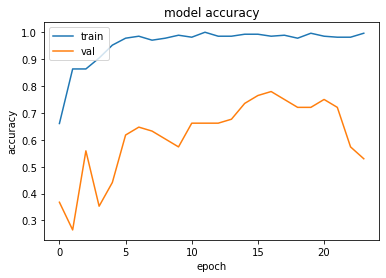

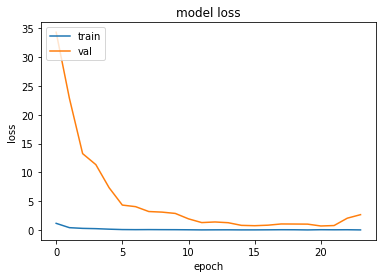

In [100]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

x_train = X_train
y_train = Y_train
x_test = X_test
y_test = Y_test

# Fit the model on training data
#history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Plot accuracy and loss curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


3/3 [==============================] - 4s 998ms/step


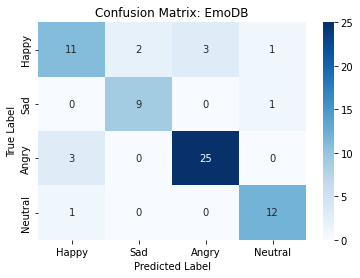

In [147]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(x_test)

# define y_true as the one-hot encoded version of the test labels
y_true = np.zeros((len(y_test), 4)) # 4 is the number of emotions being classified
y_true[np.arange(len(y_test)), y_test] = 1
predicted_labels = np.argmax(y_pred, axis=1)

y_pred = np.zeros((len(predicted_labels), 4)) # 4 is the number of emotions being classified
y_pred[np.arange(len(predicted_labels)), predicted_labels] = 1


cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
labels = ['Happy', 'Sad', 'Angry', 'Neutral'] # replace with your own emotion labels

# plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# add axis labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: EmoDB')

# show the plot
plt.show()
